<a href="https://colab.research.google.com/github/takao8/MLTSA_JClifford/blob/master/HW9/HW9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW9 PHYS667 by Jon Clifford

In this notebook, we do similar to what we did in HW8, except we extract more features using the autoencoder.  Note that HW9 starts roughly halfway down this notebook--the beginning parts are the setup we used to extract features from the dataset. 

# Task 1: setup and Data Retrieval

This step is straightforward: I downloaded the dataset from kaggle, unzipped, and got them into colab with pandas.read_csv

In [0]:
import json
import os
import pandas as pd
import numpy as np
import pylab as pl

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['interp', 'hist', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [0]:
# mounting the google drive
from google.colab import drive

drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# getting into the correst spot for the kaggle.json
cd gdrive/My\ Drive/

[Errno 2] No such file or directory: 'gdrive/My Drive/'
/content/gdrive/My Drive/MLSTA1/HW5/data


In [0]:
!chmod 600 kaggle.json

chmod: cannot access 'kaggle.json': No such file or directory


In [0]:
envs = json.load(open("kaggle.json", "r"))       # opens our kaggle.json file
os.environ["KAGGLE_USERNAME"] = envs['username']   #gets our username from the json file
os.environ["KAGGLE_KEY"] = envs['key']     #gets our key

FileNotFoundError: ignored

In [0]:
cd MLSTA1/

In [0]:
!mkdir HW5/

In [0]:
cd HW5/

In [0]:
cd data

In [0]:
# now that we're in the directory we want, we'll download and unzip
!kaggle competitions download -c PLAsTiCC-2018

In [0]:
!ls

In [0]:
!unzip training_set.csv.zip

# Task 2: Minor Data Preparation

Now that the data is downlaoded, I'll read in the 2 csv files we need and do minor prep for the notebook ahead.

In [0]:
lcvs = pd.read_csv("training_set.csv")

In [0]:
print("The dataset contains: (observations, columns)", lcvs.shape)

The dataset contains: (observations, columns) (1421705, 6)


In [0]:
lcvs.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [0]:
bands = lcvs["passband"].unique()
print("Passbands (filter) identifiers:", bands)

Passbands (filter) identifiers: [2 1 3 4 5 0]


In [0]:
objects = lcvs["object_id"].unique()
print("There are {} astrophysical simulated objects in my dataset".format(objects.shape[0]))

There are 7848 astrophysical simulated objects in my dataset


In [0]:
metadata = pd.read_csv("training_set_metadata.csv")
metadata.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [0]:
metadata.columns

Index(['object_id', 'ra', 'decl', 'gal_l', 'gal_b', 'ddf', 'hostgal_specz',
       'hostgal_photoz', 'hostgal_photoz_err', 'distmod', 'mwebv', 'target'],
      dtype='object')

In [0]:
print("The metadata dataset contains more information for each time series: (time-series, columns)", metadata.shape)

The metadata dataset contains more information for each time series: (time-series, columns) (7848, 12)


# Task 3: Data Visualization

In [0]:
norm_band = Normalize(vmin=bands.min(), vmax=bands.max())

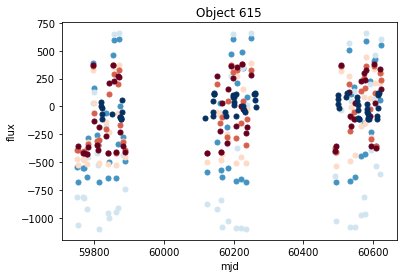

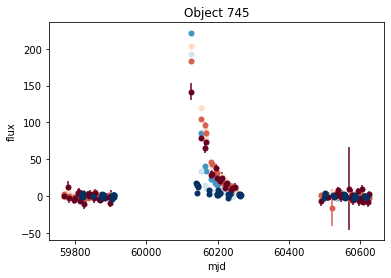

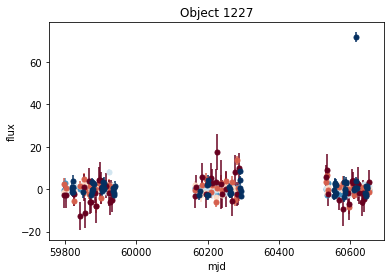

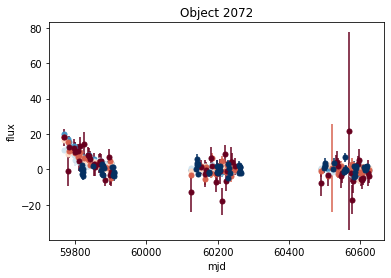

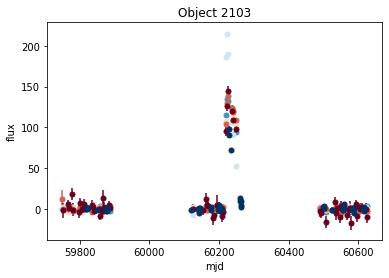

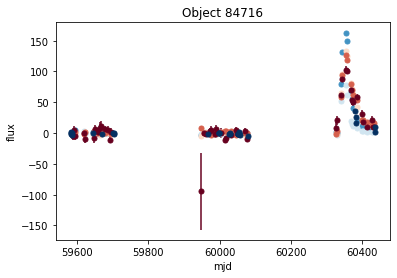

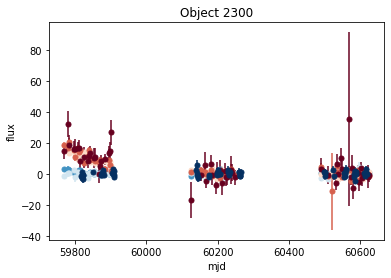

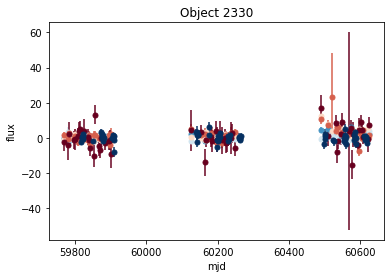

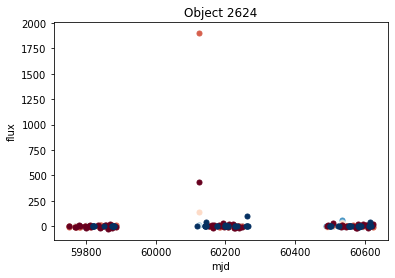

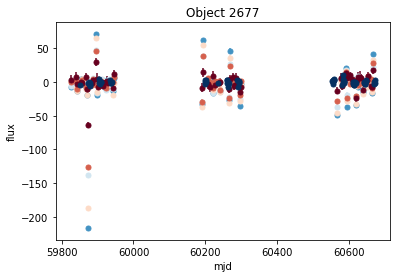

In [0]:
a = lcvs.loc[lcvs["object_id"]==objects[0]]
a.head()
for o in [objects[0], objects[3], objects[5], objects[10], objects[11], 84716, 
          objects[12], objects[13], objects[14], objects[15]]:
  for d in bands:
    a = lcvs.loc[(lcvs["object_id"]==o) & (lcvs["passband"]==d)]
    pl.errorbar(a["mjd"], a["flux"], yerr=a["flux_err"], 
      color=[pl.cm.RdBu_r(Normalize(vmin=bands.min(), vmax=bands.max())(c)) for c in bands][d-1], 
      fmt='.', ms=10, mew=1)
    pl.title("Object %s" % o)
    pl.ylabel("flux")
    pl.xlabel("mjd")
  pl.show()

Figure 1: Time series plots of multiple objects and their flux and errors.  Note that the x-axis is time, represented by the label mjd.  Note also the colorcode indicates which band each datapoint is in: points that are more red are in lower bands, while points that are more blue are in higher bands.  Significant clustering appears in all plots, one such example in Object 2103, showing the 3 clusters along flux=0 along with a cluster directed upwards at around mjd=60250.

# Task 4: Extract Features

# 4.1

After finishing this homework, I realize I wish I had more time to work on this and the t-SNE, but for this week I don't, so I only added the minimum 6 variables needed.  They are:

Original lightcurve: 3rd (skewness) and 4th (kurtosis) moments.  Like mean and variance, moments are always useful to have for a dataset.  They are continuous and are unbounded.

Standardized lightcurve: median, straight line fit.  Median is a good indicatior of the middle of the dataset when significant outliers exist, and will exist as a positive and (potentially) unbounded variable.  The line fit statistics are always useful--the slope and intercept can also technically be unbounded, but they will come as two separate variables.


Metadata: decl, ddf.  decl indicates the position in the sky, and is potentially unbounded. ddf is a binary variable, indicating the type of survey used for the data.

# 4.2 - Extracting from the Original Lightcurve

Here we'll extract the 3rd and 4th moments from the standard lightcurve.  I realize that getting the other statistics are straightforward, but for the interest of time I only got those 2.

In [0]:
from scipy import stats 
def m3(x):   # skewness
    return stats.moment(x, moment = 3)
def m4(x):   # kurtosis
    return stats.moment(x, moment = 4)
mom3 = lcvs.groupby(["object_id", "passband"]).flux.apply(m3)
mom4 = lcvs.groupby(["object_id", "passband"]).flux.apply(m4)

In [0]:
#pd.DataFrame(mom4).rename({"flux": "m3"}, axis=1)
features = pd.concat([mom3, mom4], axis=1)
features.columns=["m3", "m4"]
features.head()

m3            m4
object_id passband                            
615       0         7.266579e+04  7.433032e+07
          1         8.593916e+07  2.215166e+11
          2         3.040627e+07  6.659406e+10
          3         1.049664e+07  1.919999e+10
          4         4.717542e+06  1.036570e+10

# 4.3 - Standardizing Lightcurve and Extracting Features

In this step, we standardize the dataset using groupby and apply, then add our median and linfit statistics.

In [0]:
lcvs["fluxnormed"] = 0.

In [0]:
def normed(df):
   df["fluxnormed"] = (df.flux - df.mean().flux)/df.std().flux
   return df
lcvsnorm = lcvs.groupby(["object_id", "passband"]).apply(normed)

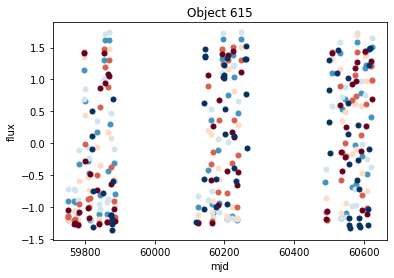

In [0]:
for d in bands:
    a = lcvsnorm.loc[(lcvsnorm["object_id"]==615) & (lcvsnorm["passband"]==d)]
    pl.errorbar(a["mjd"], a["fluxnormed"], 
      color=[pl.cm.RdBu_r(Normalize(vmin=bands.min(), vmax=bands.max())(c)) for c in bands][d-1], 
      fmt='.', ms=10, mew=1)
    pl.title("Object 615")
    pl.ylabel("flux")
    pl.xlabel("mjd")
pl.show()

Figure 2: Verification normalization worked.  Comparison to the same object in Figure 1 confirms the same shape with different magnitude.  I couldn't figure out why the colors didn't match, but the shapes do match and for purposes of the notebook is all that matters.

In [0]:
medians = lcvsnorm.groupby(["object_id", "passband"])[["fluxnormed"]].median()
features["medians"] = medians

In [0]:
def linfit(x):
    pars = np.polyfit(range(len(x)), x["fluxnormed"].values, 1)
    return pars
linfits = lcvsnorm.groupby(["object_id", "passband"]).apply(linfit)

In [0]:
slopes = [x[0] for x in linfits.values[:]]
intercepts = [x[1] for x in linfits.values[:]]
features["slopes"] = slopes
features["intercepts"] = intercepts

In [0]:
features.head()

m3            m4   medians    slopes  intercepts
object_id passband                                                            
615       0         7.266579e+04  7.433032e+07 -0.080537  0.005676   -0.175947
          1         8.593916e+07  2.215166e+11 -0.170090  0.014032   -0.399902
          2         3.040627e+07  6.659406e+10 -0.289021  0.017676   -0.503760
          3         1.049664e+07  1.919999e+10 -0.122434  0.020475   -0.583524
          4         4.717542e+06  1.036570e+10 -0.163078  0.022343   -0.636786

Thus we verify that our statistics are added correctly.

# Task 5 - Unstacking the features and adding Metadata

Note as said before that we're adding decl and ddf from the metadata file.  We make final adjustments to our features dataset and add these variables before moving on.

In [0]:
allfeatures = features.reset_index().set_index(['object_id','passband']).stack(
    ).unstack([1,2])

In [0]:
features.reset_index().head().set_index(['object_id','passband']).stack().unstack([1,2])

passband             0                          ...         4                     
                    m3            m4   medians  ...   medians    slopes intercepts
object_id                                       ...                               
615        72665.79285  7.433032e+07 -0.080537  ... -0.163078  0.022343  -0.636786

[1 rows x 25 columns]

In [0]:
allfeatures = allfeatures.merge(metadata[["decl", "object_id"]], left_on="object_id", right_on="object_id")
allfeatures = allfeatures.merge(metadata[["ddf", "object_id"]], left_on="object_id", right_on="object_id")
allfeatures = allfeatures.merge(metadata[["target", "object_id"]], left_on="object_id", right_on="object_id")

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [0]:
allfeatures.head()

,object_id,"(0, m3)","(0, m4)","(0, medians)","(0, slopes)","(0, intercepts)","(1, m3)","(1, m4)","(1, medians)","(1, slopes)","(1, intercepts)","(2, m3)","(2, m4)","(2, medians)","(2, slopes)","(2, intercepts)","(3, m3)","(3, m4)","(3, medians)","(3, slopes)","(3, intercepts)","(4, m3)","(4, m4)","(4, medians)","(4, slopes)","(4, intercepts)","(5, m3)","(5, m4)","(5, medians)","(5, slopes)","(5, intercepts)",decl,ddf,target
0,615,72665.792850,7.433032e+07,-0.080537,0.005676,-0.175947,8.593916e+07,2.215166e+11,-0.170090,0.014032,-0.399902,3.040627e+07,6.659406e+10,-0.289021,0.017676,-0.503760,1.049664e+07,1.919999e+10,-0.122434,0.020475,-0.583524,4.717542e+06,1.036570e+10,-0.163078,0.022343,-0.636786,3.041829e+06,1.049535e+10,-0.129163,0.021319,-0.596932,-61.943836,1,92
1,713,89.634243,4.907398e+03,-0.052914,-0.041433,1.429423,-1.551087e+01,1.944373e+03,0.080189,-0.051648,1.420320,-4.127475e+00,1.935955e+03,0.117188,-0.053887,1.481892,-4.249286e+01,3.091660e+03,0.141552,-0.050983,1.402038,-1.597455e+01,2.938985e+03,0.016870,-0.050464,1.387765,7.377121e+01,5.294322e+03,-0.094281,-0.037903,1.042343,-27.784405,1,88
2,730,2.093148,3.655013e+01,0.039463,-0.001798,0.063840,2.623669e+00,3.870188e+01,0.016754,0.003167,-0.080770,3.864890e+02,6.926529e+03,-0.343392,0.026905,-0.686084,1.380135e+03,4.048490e+04,-0.314425,0.024491,-0.624531,2.936931e+03,1.060595e+05,-0.308522,0.022552,-0.563811,3.751336e+03,1.860606e+05,-0.149763,0.019612,-0.490299,-6.579593,1,42
3,745,162.368381,2.575248e+03,-0.169349,-0.013089,0.464675,1.161627e+05,2.162844e+07,-0.185994,-0.003826,0.105205,1.758302e+05,3.606109e+07,-0.290606,-0.003878,0.106641,1.519142e+05,2.575691e+07,-0.373246,-0.003931,0.108112,1.190633e+05,1.781661e+07,-0.358773,-0.004774,0.131296,5.309464e+04,6.203072e+06,-0.306851,-0.002816,0.076043,-45.586655,1,90
4,1124,-4.160853,1.101222e+02,-0.033864,0.017117,-0.530614,1.202103e+03,3.545471e+04,-0.429236,0.028666,-0.816982,2.827915e+04,2.468546e+06,-0.438785,0.025384,-0.723449,6.198814e+04,7.271993e+06,-0.383411,0.021342,-0.608237,7.183273e+04,9.005039e+06,-0.303771,0.019736,-0.562470,3.414365e+04,3.279413e+06,-0.229697,0.015555,-0.435534,-63.823658,1,90


# HW9 Starts Here

-----------------------------

-----------------------------

-------------------------

We have 4 main steps involved with doing this homework:

1. Interpolate each individual passband series to an equal number of datapoints

2. Train an autoencoder with the equal-sized series and extract the bottleneck features

3. Insert the extracted features into our allfeatures matrix


4. Redo the random forest classification that we did from HW6

# Part 1: Interpolation

First: Interpolate each series by setting up Gaussian Processes.  I perform the interpolation on each individual passband.

I'll start by doing it for one series to ensure that I'm doing it correctly, then I'll add it in a for loop for every series and get our autoencoder.

Setup:

In [0]:
!pip install george
import george
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, ExpSineSquared
from george.kernels import Matern32Kernel, ConstantKernel#, WhiteKernel

     |████████████████████████████████| 1.8MB 2.8MB/s 
     |████████████████████████████████| 296kB 18.0MB/s 
  ERROR: Failed building wheel for george
  Running setup.py clean for george
Failed to build george
    Running setup.py install for george ... done


In [0]:
from scipy.optimize import minimize

Initializing our Gaussian process and its kernel:

In [0]:
kernel = ConstantKernel(5) * Matern32Kernel(5)
gp = george.GP(kernel)

In [0]:
y = lcvs.loc[lcvs["object_id"]==130779836].loc[lcvs["passband"]==2]["flux"].values  # our flux value
x = lcvs.loc[lcvs["object_id"]==130779836].loc[lcvs["passband"]==2]["mjd"].values   # instead of using mjd, we'll start everything at 0
#x = (x- min(x)) /max(x)
yerr = lcvs.loc[lcvs["object_id"]==130779836].loc[lcvs["passband"]==2]["flux_err"].values  # our errors for each value

In [0]:
lcvs.tail()

,object_id,mjd,passband,flux,flux_err,detected,fluxnormed
1421700,130779836,60555.9838,4,-39.881969,46.477093,0,0.0
1421701,130779836,60560.0459,1,14.894439,18.947685,0,0.0
1421702,130779836,60571.0225,5,30.593130,50.695290,0,0.0
1421703,130779836,60585.9974,4,-23.471439,44.819859,0,0.0
1421704,130779836,60588.0372,0,-41.214264,51.665123,0,0.0


In [0]:
gp.compute(x, yerr)

In [0]:
#newx = np.linspace(0, x[-1], 1000)
newx = np.linspace(x[0], x[-1], 100)

Optimizing the parameters of our GP:

In [0]:
def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)
result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
gp.set_parameter_vector(result.x)

In [0]:
f, sig = gp.predict(y, newx, return_var=True)

And finally, plotting our result:

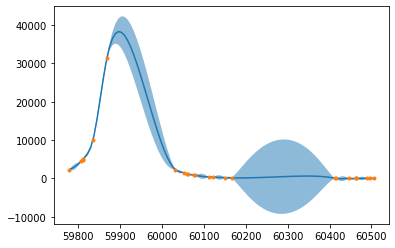

In [0]:
pl.plot(newx, f)
pl.fill_between(newx, f - np.sqrt(sig), f + np.sqrt(sig), alpha=0.5);
pl.plot(x, y, '.')

Figure 1: Results of a Gaussian process for object 130779836 and passband 2.  Note that as a result of doing this interpolation, we can evenly sample any number of datapoints we would desire along the center line.

Therefore our interpolation works, and we can continue with interpolating every series to obtain 100 points and get our feature.  We do that in the next 2 cells of code.

In [0]:
dat = []
errvals = []
gp = george.GP(kernel)

In [0]:
for val, i in enumerate(lcvs["object_id"].unique()):
  for j in lcvs["passband"].unique():
    kernel = ConstantKernel(5) * Matern32Kernel(5)
    gp = george.GP(kernel)
    y = lcvs.loc[lcvs["object_id"]==i].loc[lcvs["passband"]==j]["flux"].values
    x = lcvs.loc[lcvs["object_id"]==i].loc[lcvs["passband"]==j]["mjd"].values 
    #x = (x- min(x)) /max(x)
    yerr = lcvs.loc[lcvs["object_id"]==i].loc[lcvs["passband"]==j]["flux_err"].values
    try:
      gp.compute(x, yerr)
      newx = np.linspace(x[0], x[-1], 100)
      result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
      gp.set_parameter_vector(result.x)
      f, sig = gp.predict(y, newx, return_var=True)
      dat.append([i, j] + f.tolist())
    except:
      print('err')
      print(val)
      errvals.append(i)

The code above was actually pretty frustrating--while computing the Gaussian processes in the for loop, there were a lot of objects that produced issues of positive-definiteness.  The strange thing is that the first time I ran this code, I had very few issues with this, so I don't know what could have changed.  Either way, I kept a list called errvals which recorded the objects that had issues of positive definiteness, which I then removed them from the final dataset.

In [0]:
interp = np.array(dat)

I'll save the results from running the for loop, since it took a long time to complete.

In [0]:
np.save("data_hw9", interp)
np.save("err_hw9", np.array(errvals))

In [0]:
interp = np.load("data_hw9.npy")
errvals = np.load("err_hw9.npy")

Let's see how many observations our errvals take out of the dataset:

In [0]:
len(errvals) / len(lcvs["object_id"].unique())

0.020642201834862386

Roughly 2% of the dataset is removed, which isn't a big deal for our purposes.

Before we do the training, let's remove the error observations from the dataset:

In [0]:
newfeatures = allfeatures.loc[~allfeatures["object_id"].isin(errvals)]

In [0]:
newfeatures.head()

,object_id,"(0, m3)","(0, m4)","(0, medians)","(0, slopes)","(0, intercepts)","(1, m3)","(1, m4)","(1, medians)","(1, slopes)","(1, intercepts)","(2, m3)","(2, m4)","(2, medians)","(2, slopes)","(2, intercepts)","(3, m3)","(3, m4)","(3, medians)","(3, slopes)","(3, intercepts)","(4, m3)","(4, m4)","(4, medians)","(4, slopes)","(4, intercepts)","(5, m3)","(5, m4)","(5, medians)","(5, slopes)","(5, intercepts)",decl,ddf,target
0,615,72665.792850,7.433032e+07,-0.080537,0.005676,-0.175947,8.593916e+07,2.215166e+11,-0.170090,0.014032,-0.399902,3.040627e+07,6.659406e+10,-0.289021,0.017676,-0.503760,1.049664e+07,1.919999e+10,-0.122434,0.020475,-0.583524,4.717542e+06,1.036570e+10,-0.163078,0.022343,-0.636786,3.041829e+06,1.049535e+10,-0.129163,0.021319,-0.596932,-61.943836,1,92
1,713,89.634243,4.907398e+03,-0.052914,-0.041433,1.429423,-1.551087e+01,1.944373e+03,0.080189,-0.051648,1.420320,-4.127475e+00,1.935955e+03,0.117188,-0.053887,1.481892,-4.249286e+01,3.091660e+03,0.141552,-0.050983,1.402038,-1.597455e+01,2.938985e+03,0.016870,-0.050464,1.387765,7.377121e+01,5.294322e+03,-0.094281,-0.037903,1.042343,-27.784405,1,88
2,730,2.093148,3.655013e+01,0.039463,-0.001798,0.063840,2.623669e+00,3.870188e+01,0.016754,0.003167,-0.080770,3.864890e+02,6.926529e+03,-0.343392,0.026905,-0.686084,1.380135e+03,4.048490e+04,-0.314425,0.024491,-0.624531,2.936931e+03,1.060595e+05,-0.308522,0.022552,-0.563811,3.751336e+03,1.860606e+05,-0.149763,0.019612,-0.490299,-6.579593,1,42
3,745,162.368381,2.575248e+03,-0.169349,-0.013089,0.464675,1.161627e+05,2.162844e+07,-0.185994,-0.003826,0.105205,1.758302e+05,3.606109e+07,-0.290606,-0.003878,0.106641,1.519142e+05,2.575691e+07,-0.373246,-0.003931,0.108112,1.190633e+05,1.781661e+07,-0.358773,-0.004774,0.131296,5.309464e+04,6.203072e+06,-0.306851,-0.002816,0.076043,-45.586655,1,90
4,1124,-4.160853,1.101222e+02,-0.033864,0.017117,-0.530614,1.202103e+03,3.545471e+04,-0.429236,0.028666,-0.816982,2.827915e+04,2.468546e+06,-0.438785,0.025384,-0.723449,6.198814e+04,7.271993e+06,-0.383411,0.021342,-0.608237,7.183273e+04,9.005039e+06,-0.303771,0.019736,-0.562470,3.414365e+04,3.279413e+06,-0.229697,0.015555,-0.435534,-63.823658,1,90


And finally, we'll get our training/validation sets in preperation for training the autoencoder:

In [0]:
X_train, X_test, _, _ = train_test_split(interp[:, 2:], interp[:, 2:], test_size=0.30, random_state=8)

We'll also whiten our training/testing set, as we always should.

In [0]:
Xtrain_scaled = preprocessing.scale(X_train)
Xtest_scaled = preprocessing.scale(X_test)

# Part 2. Training the Autoencoder

Now we'll train and get features from our autoencoder:

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(90, activation="relu", kernel_initializer='he_uniform', input_dim=100),
    tf.keras.layers.Dense(70, activation="relu", kernel_initializer='he_uniform'),
    tf.keras.layers.Dense(50, activation="relu", kernel_initializer='he_uniform'),
    tf.keras.layers.Dense(25, activation="relu", kernel_initializer='he_uniform'),
    tf.keras.layers.Dense(15, activation="relu", kernel_initializer='he_uniform'),
    tf.keras.layers.Dense(25, activation="relu", kernel_initializer='he_uniform'),
    tf.keras.layers.Dense(50, activation="relu", kernel_initializer='he_uniform'),
    tf.keras.layers.Dense(70, activation="relu", kernel_initializer='he_uniform'),
    tf.keras.layers.Dense(90, activation="relu", kernel_initializer='he_uniform'),
    tf.keras.layers.Dense(100)])

Next we compile the model.  We used the Adam optimizer, which is a standard in the machine learning community as a good SGD optimizer.  I initially had the learning rate around 0.001, but that proved to be way to high for this model, so I lowered it by a factor of 100 to 0.00001.

Additionally, I choose to use the L2 norm as our loss metric.  Since this is a complex (non-binary and non-multiclass) problem, I believed mse would be the most appropriate in this case.

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005), 
                  loss='mse')

I created my callback to have patience=300, saying that if the validation data isn't lower after 300 epochs, stop the training and reload the minimum weights. 

In [0]:
yes = tf.keras.callbacks.EarlyStopping(min_delta = 0, verbose=1, 
                                       patience=300, mode="min", restore_best_weights=True)

And now we fit our model with batch_size=32.  batch_size is another variable we could likely optimize for our fitting, but for our purposes I kept it fairly low as to prevent overfitting, but not too high to make the fitting process take forever.

In [0]:
hist = model.fit(Xtrain_scaled, Xtrain_scaled, verbose=1, validation_data=(Xtest_scaled, Xtest_scaled), 
                 epochs=3000, batch_size=32, callbacks=[yes])

In [0]:
model.save_weights("ourmod")

In [0]:
model.load_weights("ourmod")  # recovering the model just in case

We plot the training vs validation error to verify that our model converged to where we want:

Text(0, 0.5, 'MSE')

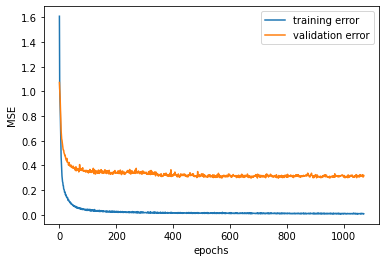

In [0]:
pl.plot(model.history.history["loss"], label="training error")
pl.plot(model.history.history["val_loss"], label="validation error")
pl.legend()
pl.xlabel("epochs")
pl.ylabel("MSE")

Figure 2: Training and Validation MSE error vs the number of epochs.  Although there's a lack of visibility of the validation data going up, by the end it not decrease in value within the last 300 epochs, resulting in the callback to be activated.

In [0]:
interps = preprocessing.scale(interp[:, 2:])

In [0]:
from keras import backend as K
# input placeholder
inp = model.input                   
# extract the bottle neck outputs
outputs = model.layers[4].output     
# create a function to evaluate the output of the bottle neck layer for a given input
functors = K.function([inp], [outputs])    

# Testing
layer_outs = functors(interps)

Using TensorFlow backend.


In [0]:
tot = pd.DataFrame(layer_outs[0])

In [0]:
tot.insert(0, "object_id", interp[:, 0].astype(int))
tot.insert(1, "passband", interp[:, 1].astype(int))

The crazy thing we could do is add 15*6 = 90 new features to each row and do the classification.  I'm not going to do that here, although I don't think it's a completely bad idea.  I choose to take the mean over all passbands, and feed in 15 new features for each object.

In [0]:
before = tot.groupby("object_id").mean()
before = before.drop("passband", axis=1)

In [0]:
after = pd.merge(newfeatures, before, on="object_id")  # our final big matrix

# Doing the Gradient Boosted RF

Now we can redo our classification task for the random forest.  Since we saw a noticable improvement in classification accuracy by splitting the data based on the type of survey (ddf), we will continue to do that for this section.

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
afterafter = after.drop(["object_id"], axis=1)
allfeat0 = afterafter.loc[allfeatures["ddf"]==0]
allfeat1 = afterafter.loc[allfeatures["ddf"]==1]

In [0]:
# features and target for ddf=0
X1 = allfeat0.drop("target", axis=1).values
y1 = allfeat0["target"].values

# features and target for ddf=1
X2 = allfeat1.drop("target", axis=1).values
y2 = allfeat1["target"].values

# our final datasets:
X_trdf, X_tedf, y_trdf, y_tedf = train_test_split(X1, y1, test_size=0.2)
X_trnorm, X_tenorm, y_trnorm, y_tenorm = train_test_split(X2, y2, test_size=0.2)

This gradient boosted forest differs from the regular random forest in that it doesn't create a parallel of independent trees--the trees are created in a sequence, and the features/observations are weighted for each tree of the sequence depending on the classification of the last tree.  The term "Gradient Boosted" refers to the fact that gradient descent is set up on an optimization problem to determine how to adjust the features and observations for the next step.  

In [0]:
from sklearn.ensemble import GradientBoostingClassifier

In [0]:
gbdf = GradientBoostingClassifier(max_depth=5)

Note now that we now have the parameter "learning rate" in our gradient boosting classifier, which is indicative of the fact that we're reweighting our features and observations in each step.  In our application, we won't mess with it.

First, for ddf:

In [0]:
gbdf.fit(X_trdf, y_trdf)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [0]:
gbdf.score(X_tedf, y_tedf)

0.6081923419412288

Note: score before was 0.5801.  Now we got a score of 0.6082, a 2.8% improvement.  A lot more tests would have to be done to ensure this isn't just a statistical fluke, but right now it looks good.

And now for normal:

In [0]:
gbnorm = GradientBoostingClassifier()

In [0]:
gbnorm.fit(X_trnorm, y_trnorm)
gbnorm.score(X_tenorm, y_tenorm)

0.6957547169811321

Note, before we got 0.74764.  Now it's 0.6958, a roughly 5% decrease.  Again, I don't know if this is a statistical fluke, and a lot more testing would need to be done to verify this result.

In [0]:
print("Gradient Boosted Random Forest Classification\n" + 
       "score on DDF {:.2f} and on normal survey {:.2f}".format(
           gbdf.score(X_tedf, y_tedf),
           gbnorm.score(X_tenorm, y_tenorm)))

Gradient Boosted Random Forest Classification
score on DDF 0.61 and on normal survey 0.70


There are a lot of things that we can adjust in this model that could improve this result.  I want to go over a few things here.

# Possible Adjustments to the Model

1. Instead of taking the mean over the 6 extracted features in each passband, there are different manipulations on the features that we can do to get more information.  I don't know if taking the mean over the autoencoder features decreased the information the model took, although I suspect it did.  If I were doing this in a kaggle competition, I would likely add all 90 features to the end of each row, then run the autoencoder again to see the results.  If it's too slow or if the results still didn't improve, I would consider a dimensionality reduction technique.  But either way, taking the mean over the features is probably the easiest way to lose signal.

2. I need to be careful with the Gaussian process curves that I fitted to the objects, as they can produce values that simply aren't right.  For example, looking at object 615:

Text(0.5, 0, 'mjd')

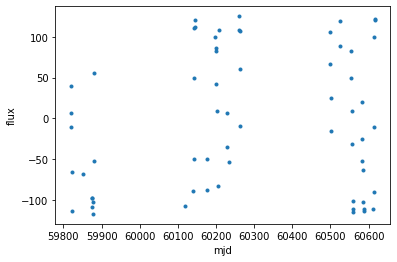

In [0]:
t = lcvs.loc[(lcvs["object_id"]==615) & (lcvs["passband"]==0)]
pl.plot(t["mjd"], t["flux"], '.')
pl.ylabel("flux")
pl.xlabel("mjd")

The Gaussian process for this plot would have been chaotic.  Redoing the Gaussian process fit for this object gives us:

In [0]:
kernel = ConstantKernel(5) * Matern32Kernel(5)
gp = george.GP(kernel)

In [0]:
y = lcvs.loc[lcvs["object_id"]==615].loc[lcvs["passband"]==2]["flux"].values  # our flux value
x = lcvs.loc[lcvs["object_id"]==615].loc[lcvs["passband"]==2]["mjd"].values   # instead of using mjd, we'll start everything at 0
#x = (x- min(x)) /max(x)
yerr = lcvs.loc[lcvs["object_id"]==615].loc[lcvs["passband"]==2]["flux_err"].values  # our errors for each value

In [0]:
gp.compute(x, yerr)

In [0]:
#newx = np.linspace(0, x[-1], 1000)
newx = np.linspace(x[0], x[-1], 100)

In [0]:
def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)
result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
gp.set_parameter_vector(result.x)

In [0]:
f, sig = gp.predict(y, newx, return_var=True)

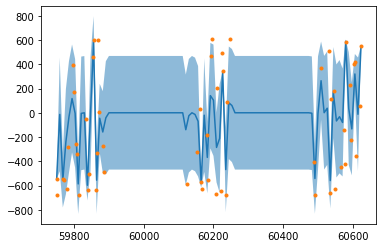

In [0]:
pl.plot(newx, f)
pl.fill_between(newx, f - np.sqrt(sig), f + np.sqrt(sig), alpha=0.5);
pl.plot(x, y, '.')

And in my analysis, I evenly sampled each fitted Gaussian process.  There's obviously a better way to sample these instead of the naive way that I did, and I strongly believe this could have affected the outcome.

3. The hyperparameters of the autoencoder of course should also be manipulated.  For this case, I evenly extracted 100 points from each Gaussian process, resulting in an inputdim=100 for our autoencoder.  I might have been advised to extract 1000 points, then decrease the layers until the bottleneck was 100 neurons.  Any of these choices might affect the outcome of our model.

Overall, although my added features didn't improve the model, I don't think that's the end of the story.  There are so many options we can take to adjust and optimize this model.